# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [14]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, stop_words='english')
#         ,ngram_range=(1,2) removed from HashingVectorizer above
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/moviereviews_train.tsv', my_random_seed=24)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train1'}
{'Pos': 9992, 'Neg': 10008, 'TP': 9803, 'TN': 9842, 'FP': 166, 'FN': 189, 'Accuracy': 0.98225, 'Precision': 0.9833483799779316, 'Recall': 0.9810848678943155, 'desc': 'svm_train50'}
{'Pos': 9992, 'Neg': 10008, 'TP': 9793, 'TN': 9849, 'FP': 159, 'FN': 199, 'Accuracy': 0.9821, 'Precision': 0.9840233118971061, 'Recall': 0.980084067253803, 'desc': 'svm_train100'}
{'Pos': 9992, 'Neg': 10008, 'TP': 9723, 'TN': 9888, 'FP': 120, 'FN': 269, 'Accuracy': 0.98055, 'Precision': 0.9878085949405669, 'Recall': 0.9730784627702161, 'desc': 'svm_train500'}
{'Pos': 9992, 'Neg': 10008, 'TP': 9650, 'TN': 9915, 'FP': 93, 'FN': 342, 'Accuracy': 0.97825, 'Precision': 0.9904546854151699, 'Recall': 0.9657726180944756, 'desc': 'svm_train1000'}


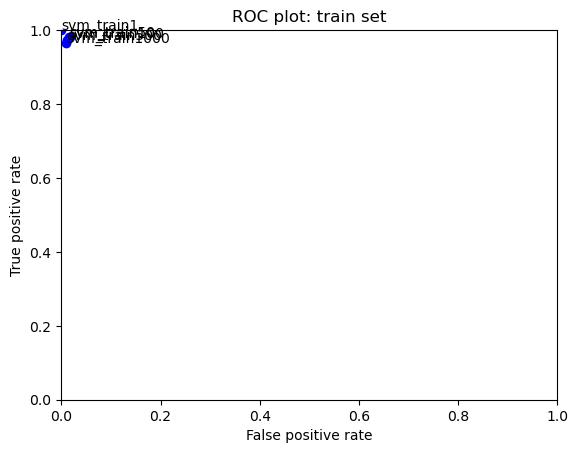

In [23]:
from sklearn import linear_model

alpha_values = [1, 50, 100, 500, 1000]
performance_measures =[]

for a in alpha_values: 
    svm = linear_model.SGDClassifier(alpha=a)
    svm.fit(X_train, y_train)

    svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train'+ str(a))
    svm_performance_train.compute_measures()
    performance_measures.append(svm_performance_train)

    print(svm_performance_train.performance_measures)


for measures in performance_measures:
    plt.plot(measures.performance_measures['FP'] / measures.performance_measures['Neg'], 
             measures.performance_measures['TP'] / measures.performance_measures['Pos'], 'bo')
    plt.text(measures.performance_measures['FP'] / measures.performance_measures['Neg'], 
             measures.performance_measures['TP'] / measures.performance_measures['Pos'], measures.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [13]:
print('OLS ROC AUC: ', roc_auc_score(y_train,ols.predict(X_train)))
print('SVM ROC AUC: ', roc_auc_score(y_train,svm.predict(X_train)))
print('LGS ROC AUC: ', roc_auc_score(y_train,lgs.predict(X_train)))
print('NBS ROC AUC: ', roc_auc_score(y_train,nbs.predict(X_train)))
print('PRC ROC AUC: ', roc_auc_score(y_train,prc.predict(X_train)))
print('RDG ROC AUC: ', roc_auc_score(y_train,rdg.predict(X_train)))
print('RDF ROC AUC: ', roc_auc_score(y_train,rdf.predict(X_train)))

OLS ROC AUC:  0.5121766877930801
SVM ROC AUC:  1.0
LGS ROC AUC:  1.0
NBS ROC AUC:  0.9964499577279728
PRC ROC AUC:  1.0
RDG ROC AUC:  1.0
RDF ROC AUC:  0.7772008574085488


### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [14]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [15]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
160
I saw this in the market place at the Cannes Film Festival. <br /><br />It's a real cheapo prod - nothing wrong with that but you have to make up for it with a bit of sex or gore or both. <br /><br />Think Larry Cohen. <br /><br />Sean Young is an interesting actor - well done to the producers for hooking her I guess.<br /><br />The opening scene in the space-ship coming down is hilarious - you could picture all the crew hands shaking it around! <br /><br />Ha ha - but I wish the people who made this well - at least it's not pretentious.
* * * * * * * * * 
240
Considering that I felt like picking up a new Jet Li film to see some but kicking and brainless hand to hand fighting, I grabbed this title.<br /><br />Unfortunatly, this movie contains more gun battles (ala Chow Yun Fat but nowhere near as good), than Jet Li and company's acrobatic fighting. Thus it was a let down.<br /><br />The faucet fighting was interesting and even funny, considering this wa

2298
This series gets 2 stars solely because it puts some of Dickens' Bleak House on film and perhaps someone will read the book. Contrary to what is probably received opinion, Diana Rigg was poor as Lady Dedlock. She was clunky and wooden. Lady D. is a reserved character but not a martinet. Denholm Elliot is wrong, wrong, wrong for Mr. Jarndyce. So I'll interrupt myself and respond to all those people who are saying: \I didn't read the book, so I don't have to take this guy's opinion because he's basing his evaluations on the book.\" True and not true. For ex, Diana Rigg is bad in her role because of poor acting whether or not you've read the book. On the other hand, Denholm Elliot is a passable Jarndyce (although too old). The series fails not because it's unfair to compare it to the book, but because the various plot lines and characters just don't coalesce to make a coherent, dramatic, mysterious andcompelling entertainment. It is dull and flat. If you want to make apossibly good B

4217
Marlon Brando had long since lost interest in acting when he made this film. His performance as \The Swede\" is the worst of his career, and that is precisely what he intended it to be. He doesn't overact. Instead, he simply acts in a bizarre fashion and pokes fun at his embarrassingly gargantuan girth. The scene where Brando climbs over the toilet stall is probably the worst, funniest moment in the history of cinema. As we witness him fall head-first into a toilet, it is hard to believe that we are watching the same actor who starred in A Streetcar Named Desire, On the Waterfront, and The Godfather.<br /><br />I guess the real question is why Marlon behaved like this in his later years. Was he sick of the movie business? Did he just like making a complete and utter fool out of himself? I guess we'll never know. But this film serves as a fascinating study as to what bad acting is all about.<br /><br />On that note, watch fellow acting veteran Donald Sutherland as he struggles to d

5443
I was sooooo excited to see this movie after finally reading the book this week. My 13 year old son was looking forward to it too. I rented it and snuggled down to enjoy a classic holiday story brought to life on screen.<br /><br />Boy, was I disappointed. This movie veered off from the book more times than is forgivable. George C. Scott is an excellent actor but in this, it seemed that he was fully into character only about 20% of the time. The rest of the time he was quite flat.<br /><br />I realize that this was made in '84, pre-CG effects, for the most part. But it looked to be very B-movie quality, especially the encounter with Jacob Marley.<br /><br />The biggest disappointment was the fact that they left out one of the most moving parts of the story: When the Spirit of Christmas Present takes Scrooge on the whirlwind tour of the world, observing people in the bleakest of circumstances still having the light and love of Christmastime.<br /><br />I will admit that Mr. Scott d

7502
Despite positive reviews and screenings at the international festivals, this movie is not for everyone.<br /><br />The story is very similar to other movies, in which a teenage girl from the family of immigrants needs to overcome many common personal problems of her age, and also to struggle against the pressure of ethnic traditions in her family. She does that by choosing some kind of sport, and with the help of a local boy, that for some reason falls in love with her, she confronts her problems and wins.<br /><br />In Girlfight it's boxing, in Bend it like Beckham it's soccer, and now it's Kung Fu.<br /><br />But Fighter is much inferior product than these two, it was simply embarrassing to watch it. Semra Turan, the \actress\" that playing the role of a teenage girl, maybe can do a lot of things, but one thing she can't do is to act. Her presence on the screen is anemic and clumsy, the dramatic situations, in which she tries to show some emotions, are dreadful, her body and fac

9353
OK, If you're looking for another Bastketball Diaries, this is completely the wrong film.<br /><br />I revolves around two brothers. Max, the younger, has a major cocaine addiction. Adam, the eldest, is a doctor. This movie is suppose to show the plunge from reality to the extreme lows that drugs make possible. It however, does not. It shows that cocaine can be fun no matter what the situation happens to be present. Most of the movie focus is on Max and his parting ways. Eventually Adam, can no longer take the stress from his job and begins to use as well (perscription drugs).<br /><br />This movie has almost no climax. Doesn't descend into what cocaine really does to you, has boring and low-budget scenes, and the acting of the eldest brother, Adam, is horrific.<br /><br />I have no idea how this movie has managed to pass and receive awards, it is not a heart-wencher. If you want a clear and true story movie on the extreme world of drugs- rent, if not buy 'The Basketball Diaries'.

10720
The 3-D featured in \The Man Who Wasn't There\" stands for DUMB, DUMB, DUMB! This inept comedy features lousy 3-D effects that makes the 3-D effects in \"Jaws 3\", \"Amityville 3\", and \"Friday the 13th Part 3\" look better by comparison. Not to mention the movie is asinine to the extreme. This was one of many 1983 movies to feature the pop-off-the-screen effects. Steve Guttenberg and Jeffrey Tambor got trapped in this mess, but at least it didn't kill their careers. Tambor would go on to star on HBO's \"The Larry Sanders Show\" and Ron Howard's box office smash \"How the Grinch Stole Christmas\", while Guttenberg followed this flop with \"Police Academy\" and \"Cocoon\". What them in those projects instead of them here in \"The Man Who Wasn't There\". If you do, you'll regret it.<br /><br />1/2* (out of four)"
* * * * * * * * * 
10870
The Wicker Man Has Done The Impossible! It replaced Cat Woman as the worst recent movie in my steel trap cinema mind. YES it's really that bad. S

13128
In what seemed like the longest 1hour 35 I've had to endure in a long time, Al Pacino delivers an accurate performace to be sure. Not his usual typecasting, which was nice. But his character was just truely pathetic. Someone to pitty as he stumbles around forgetting appointments as we realise that the Hollywood social life has drained him of his life energy. But in this movie we needed someone to like. And for some reason, every character in the picture said \I don't know why I like you, Eli\" to Al Pacino's chracter and I couldn't even come close to liking him.<br /><br />All the other actors played their usual styles. Tea Leoni, Richard Schiff, and Bill Nunn did nothing to change their established personas developed on TV or in earlier films. And Kim Basinger wasn't even in the film long enough to deliver a performance of any kind.<br /><br />The movie's story had no momentum. Most scenes never driving the story forward, but rather just collecting factoids about characters whic

13924
I'm actually watching this film as I write this . . . If the following comments \prove my lack of development as a true, artistic film maker\", then so be it . . .<br /><br />But . . . I thought (am still thinking as I'm presently viewing) that this film . . . to put it mildly, is very, very overrated. Again, very.<br /><br />It looks like a really, really bad student film done by a someone with beyond extremely limited resources . . . and who didn't pay that much attention to detail.<br /><br />I don't want to go on and on regarding all the different ways that I find this film lacking, but . . . well . . . I just don't get it (rememeber, I fully admit that maybe it's ME that's the idiot here - not the film maker - for not getting this \"piece of imaginative genius\") . . . I rented this on a whim because the reviews were very, very outstanding . . .<br /><br />Sheesh . . ."
* * * * * * * * * 
13944
What's happening to RGV? He seems to repeat himself in every movie. Has he run ou

16889
Well this movie actually made me feel so strongly that I signed up for an IMDb account just to warn people. It is patently AWFUL!! NOTHING makes sense in this movie. There is way too many subplots for a start. Josh Hartnett's character is an aspiring actor and yoga instructor as well as a cop who seems to be living way beyond his means and only teaches yoga to hot girls (Some of whom wait naked in his jacuzzi for when he comes back from work). Add to that the fact that his dad was killed by a crooked cop who just so happens to be in on the current crime being investigated by the hapless duo. Harrison Ford's character is trying to sell real estate on the side and is sleeping with the Internal Affairs investigator's ex-wife who happens to run a psychic radio show which Ford's character calls from time to time. NONSENSE!!<br /><br />I can't remember the characters names (that's how forgettable this is) so I'll refer to them as Ford and Hartnett.<br /><br />Then there's the dialogue 

18353
I have a severe problem with this show, several actually. A simple list will suffice for now, I'll go into more depth later on: superficial characters, a laugh-track and boring humour.<br /><br />If you don't wish to look at the rest of this review and are only reading it so you can feel superior (as if you see anything in this show I didn't) to a frequently irked teen from Canada I'll summarize: Friends sucks, not only because it is unfunny but because it destroyed the TV audiences for new, good shows (Arrested Development, Dexter etc.). Friends is as much to blame for reality TV, \Two And A Half Men\" and \"The King Of Queens\" as the television executives. Now then, on with the review.<br /><br />These characters have no soul, they are exactly the same in every way (outside of gender and hair colour). They react the same way in boring situations and are completely secure in their own bodies. Where is the conflict and the humour that comes with it? Why isn't Rachel storming out

19852
Never cast models and Playboy bunnies in your films! Bob Fosse's \Star 80\" about Dorothy Stratten, of whom Bogdanovich was obsessed enough to have married her SISTER after her murder at the hands of her low-life husband, is a zillion times more interesting than Dorothy herself on the silver screen. Patty Hansen is no actress either..I expected to see some sort of lost masterpiece a la Orson Welles but instead got Audrey Hepburn cavorting in jeans and a god-awful \"poodlesque\" hair-do....Very disappointing....\"Paper Moon\" and \"The Last Picture Show\" I could watch again and again. This clunker I could barely sit through once. This movie was reputedly not released because of the brouhaha surrounding Ms. Stratten's tawdry death; I think the real reason was because it was so bad!"
* * * * * * * * * 
19887
I'm 47 years old and I've spent as much of my life as I can remember, a fan of horror and sci-fi films. Be they silent, black and white, no budget or big budget, there are very

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: SVM, linear

In [29]:
from sklearn import linear_model

alpha_values = [1, 50, 100, 500, 1000]
performance_measures_test =[]

for a in alpha_values: 
    svm = linear_model.SGDClassifier(alpha=a)
    svm.fit(X_test, y_test)

    svm_performance_test = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_test'+ str(a))
    svm_performance_test.compute_measures()
    performance_measures_test.append(svm_performance_test)

    print(svm_performance_test.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 7989, 'TN': 7696, 'FP': 2312, 'FN': 2003, 'Accuracy': 0.78425, 'Precision': 0.7755557712843413, 'Recall': 0.7995396317053642, 'desc': 'svm_test1'}
{'Pos': 9992, 'Neg': 10008, 'TP': 7726, 'TN': 8282, 'FP': 1726, 'FN': 2266, 'Accuracy': 0.8004, 'Precision': 0.817393144308083, 'Recall': 0.7732185748598879, 'desc': 'svm_test50'}
{'Pos': 9992, 'Neg': 10008, 'TP': 7603, 'TN': 8363, 'FP': 1645, 'FN': 2389, 'Accuracy': 0.7983, 'Precision': 0.8221237024221453, 'Recall': 0.7609087269815853, 'desc': 'svm_test100'}
{'Pos': 9992, 'Neg': 10008, 'TP': 7254, 'TN': 8566, 'FP': 1442, 'FN': 2738, 'Accuracy': 0.791, 'Precision': 0.8341766329346826, 'Recall': 0.7259807846277022, 'desc': 'svm_test500'}
{'Pos': 9992, 'Neg': 10008, 'TP': 8429, 'TN': 7543, 'FP': 2465, 'FN': 1563, 'Accuracy': 0.7986, 'Precision': 0.773728657976868, 'Recall': 0.8435748598879104, 'desc': 'svm_test1000'}


### ROC plot to compare performance of various models and fits

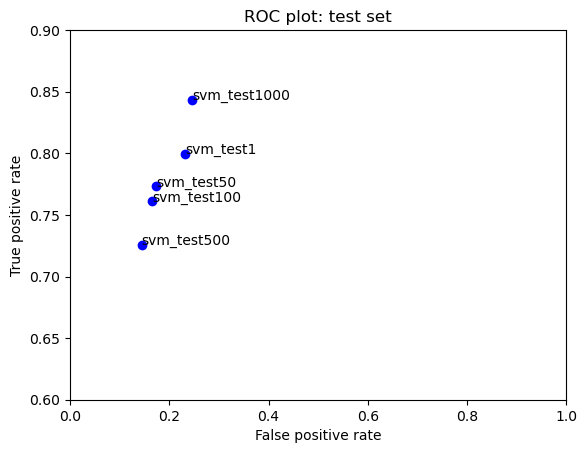

In [32]:
for measures in performance_measures_test:
    plt.plot(measures.performance_measures['FP'] / measures.performance_measures['Neg'], 
             measures.performance_measures['TP'] / measures.performance_measures['Pos'], 'bo')
    plt.text(measures.performance_measures['FP'] / measures.performance_measures['Neg'], 
             measures.performance_measures['TP'] / measures.performance_measures['Pos'], measures.desc)
plt.axis([0, 1, 0.6, 0.9])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

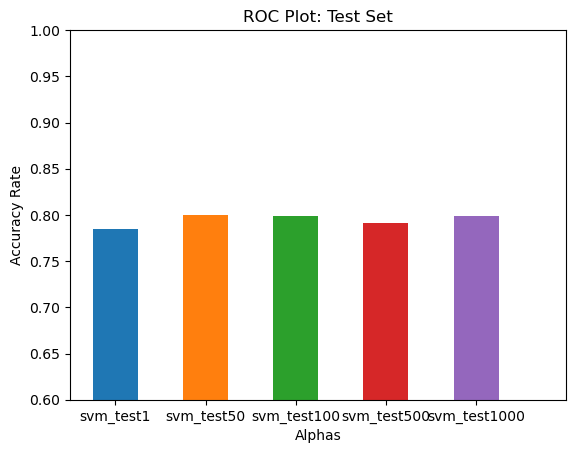

In [50]:
for measures in performance_measures_test:

    plt.bar(measures.desc, measures.performance_measures['Accuracy'], width = 0.5)
    plt.axis([-0.5,5, 0.6, 1])

plt.xlabel("Alphas")
plt.ylabel("Accuracy Rate")
plt.title("ROC Plot: Test Set")
plt.show()

In [18]:
# print('SVM ROC AUC: ', roc_auc_score(y_test,svm.predict(X_test)))

OLS ROC AUC:  0.5090052122133731
SVM ROC AUC:  0.792777398040556
LGS ROC AUC:  0.78823431151935
NBS ROC AUC:  0.7491398311918714
PRC ROC AUC:  0.7902215318684864
RDG ROC AUC:  0.8281668804288554
RDG2 ROC AUC:  0.8281668804288554
RDG3 ROC AUC:  0.829163690636192
RDG4 ROC AUC:  0.8311637111164019
RDG5 ROC AUC:  0.8331586115441822
RDF ROC AUC:  0.7500316803244066


---

# <span style="color:red">SUBMISSION</span>

---

In [19]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/moviereviews_test.tsv', my_random_seed=24, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

### Submission 1: I'll be choosing the Ridge Regression model fit with an alpha=10,000.

In [30]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg5.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48432


In [31]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [32]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [33]:
my_submission.shape

(25000, 2)

In [34]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/stephaniedang/Documents/Documents/MSDV_Spring_2023/Machine_Learning/assignment1/moviereviews_submission1.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation